## Tasks and Questions:
1. What are your preliminary observations?
2. Create features:
    - Explain your reasoning behind the features
3. Assess the quality of your model and explain.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
from helpers.encoders import weighted_mean_k_fold_target_encoding, clean_and_split_string
# 'KYC' stands for 'Know Your Customer'
#    - a process of identifying and verifying the client's identity when opening an account and periodically over time

In [12]:
df_users = pd.read_csv('datasets/Revolut/users.csv')
print(f'Shape: {df_users.shape}')
# make 'IS_FRAUDSTER' the first column since it's the target variable
df_users = df_users[['IS_FRAUDSTER'] + [col for col in df_users.columns if col != 'IS_FRAUDSTER']]

######## FEATURE ENGINEERING ########
# Label encode the 'IS_FRAUDSTER' column. Very imbalanced dataset. 
df_users['IS_FRAUDSTER'] = df_users['IS_FRAUDSTER'].astype('category').cat.codes

# make 'HAS_EMAIL' a categorical variable
df_users['HAS_EMAIL'] = df_users['HAS_EMAIL'].astype('category').cat.codes

# drop 'TERMS_VERSION'. 8 unique values. Unlikely to be useful. 1527 null values for 'TERMS_VERSION' column.
df_users = df_users.drop(columns=['TERMS_VERSION'])

# 'STATE' column has 2 unique values 'ACTIVE' and 'LOCKED'. It appears to describe the state of the account. Make it a categorical variable, but this variable could cause data leakage.
df_users['STATE'] = df_users['STATE'].astype('category').cat.codes

# 'BIRTH_YEAR' appears to have an expected left skewed distribution with min value of 1927 and max of 2000. Bin encode this column by decade to be ordinal categorical variable.
df_users['BIRTH_YEAR'] = df_users['BIRTH_YEAR'].astype('string').str[:-1] + '0'
df_users['BIRTH_YEAR'] = df_users['BIRTH_YEAR'].astype('category').cat.codes

# 'KYC' has 4 unique values: 'PASSED', 'NONE', FAILED', 'PENDING'. One-hot encode this column or target encode it.
df_users = pd.get_dummies(df_users, columns=['KYC'], dtype='int8')
# drop because it has the larget number of values. This will avoid colinearity
df_users.drop(columns=['KYC_PASSED'], inplace=True)
# 'FAILED_SIGN_IN_ATTEMPTS' is an ordinal variable, but there might be non-linear relationships. 


# 'CREATED_DATE' is a datetime column.
df_users['CREATED_DATE'] = pd.to_datetime(df_users['CREATED_DATE'])
# get YYYY-MM from 'CREATED_DATE' column
# df_users['CREATED_YYYY_MM'] = df_users['CREATED_DATE'].dt.to_period('M').astype(str)
# df_users['CREATED_DAY_OF_MONTH'] =df_users['CREATED_DATE'].dt.day
df_users['CREATED_DAY_OF_WEEK'] = df_users['CREATED_DATE'].dt.dayofweek
df_users['CREATED_HOUR'] = df_users['CREATED_DATE'].dt.hour
df_users['CREATED_MONTH'] = df_users['CREATED_DATE'].dt.month
# target encode 'CREATED_DATE' engineered features to see the variance of the target variable over time
# There doesn't seem to be a strong trend in fraud over time.
# df_users['CREATED_YYYYMM_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_YYYY_MM', 'IS_FRAUDSTER', k=5, smoothing=1)
# There is not a convincing trend in fraud by day of the month.
# df_users['CREATED_DAY_OF_MONTH_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_DAY_OF_MONTH', 'IS_FRAUDSTER', k=5, smoothing=1)
# There seems to be a non-linear monthly trend in fraud.
df_users['CREATED_MONTH_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_MONTH', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle_random_state=42, stratified=True)
# There is a strong linear day-of-the week trend in fraud.
df_users['CREATED_DAY_OF_WEEK_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_DAY_OF_WEEK', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle_random_state=42, stratified=True)
# Fraud seems to happen most often in the night time.
df_users['CREATED_HOUR_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_HOUR', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle_random_state=42, stratified=True)
# drop 'CREATED_DATE' column
df_users.drop(columns=['CREATED_DATE'], inplace=True)

# split 'PHONE_COUNTRY' column into list of countries
df_users['PHONE_COUNTRY'] = df_users['PHONE_COUNTRY'].apply(lambda x: x.split('||') if pd.notnull(x) else x)
# Target encode phone countries
df_users_phone_country = df_users.copy(deep=True)
df_users_phone_country = df_users_phone_country.explode('PHONE_COUNTRY')
df_users_phone_country['PHONE_COUNTRY_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users_phone_country, 'PHONE_COUNTRY', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle=True, kf_shuffle_random_state=42)
df_users['PHONE_COUNTRY_TARGET_ENC'] = df_users_phone_country.groupby(df_users_phone_country.index).agg({'PHONE_COUNTRY_TARGET_ENC': 'mean'})
# Count encode phone countries
df_users['PHONE_COUNTRY_COUNT_ENC'] = df_users['PHONE_COUNTRY'].apply(len)
df_users['COUNTRY_NOT_IN_PHONE_COUNTRY'] = df_users.apply(lambda x: x['COUNTRY'] not in x['PHONE_COUNTRY'], axis=1).astype('int8')
# drop 'PHONE_COUNTRY' column
df_users.drop(columns=['PHONE_COUNTRY'], inplace=True)
# Target encode 'COUNTRY' column
df_users['COUNTRY_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'COUNTRY', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle=True, kf_shuffle_random_state=42)
# # drop 'COUNTRY' column
df_users.drop(columns=['COUNTRY'], inplace=True)
# TODO: Make visualizations for and evaluations of engineered features

df_users.head()

Shape: (9944, 11)


,IS_FRAUDSTER,ID,HAS_EMAIL,STATE,BIRTH_YEAR,FAILED_SIGN_IN_ATTEMPTS,KYC_FAILED,KYC_NONE,KYC_PENDING,CREATED_DAY_OF_WEEK,CREATED_HOUR,CREATED_MONTH,CREATED_MONTH_TARGET_ENC,CREATED_DAY_OF_WEEK_TARGET_ENC,CREATED_HOUR_TARGET_ENC,PHONE_COUNTRY_TARGET_ENC,PHONE_COUNTRY_COUNT_ENC,COUNTRY_NOT_IN_PHONE_COUNTRY,COUNTRY_TARGET_ENC
0,0,1872820f-e3ac-4c02-bdc7-727897b60043,1,0,5,0,0,0,0,6,7,8,0.0348,0.0236,0.0125,0.0617,4,0,0.0602
1,0,545ff94d-66f8-4bea-b398-84425fb2301e,1,0,6,0,0,0,0,1,10,3,0.0572,0.0334,0.0278,0.0613,4,0,0.0593
2,0,10376f1a-a28a-4885-8daa-c8ca496026bb,1,0,5,0,0,0,0,3,4,5,0.0324,0.0339,0.0930,0.0059,1,0,0.0064
3,0,fd308db7-0753-4377-879f-6ecf2af14e4f,1,0,6,0,0,0,0,4,17,6,0.0211,0.0287,0.0228,0.0019,1,0,0.0019
4,0,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,0,6,0,0,0,0,2,15,8,0.0436,0.0345,0.0420,0.0610,4,0,0.0593


In [9]:
df_users[df_users.apply(lambda x: x['COUNTRY'] not in x['PHONE_COUNTRY'], axis=1)]

,IS_FRAUDSTER,ID,HAS_EMAIL,PHONE_COUNTRY,STATE,COUNTRY,BIRTH_YEAR,FAILED_SIGN_IN_ATTEMPTS,KYC_FAILED,KYC_NONE,KYC_PENDING,CREATED_DAY_OF_WEEK,CREATED_HOUR,CREATED_MONTH,CREATED_MONTH_TARGET_ENC,CREATED_DAY_OF_WEEK_TARGET_ENC,CREATED_HOUR_TARGET_ENC,PHONE_COUNTRY_TARGET_ENC,PHONE_COUNTRY_COUNT_ENC
50,0,0aa06081-4ea7-4791-b00d-e4e5ea510837,1,"[US, PR, CA]",0,IT,7,0,0,1,0,6,13,5,0.0259,0.0208,0.0274,0.0486,3
85,0,f2318b2b-f057-4cfe-94d1-15fe869790b2,1,[FR],0,GB,7,0,0,0,0,3,15,3,0.0550,0.0281,0.0420,0.0019,1
91,0,f140f12c-6b93-462a-acb1-7690ec773477,1,[FR],0,GB,7,0,0,0,0,4,13,6,0.0222,0.0306,0.0314,0.0029,1
107,0,1161adca-2a97-45c5-9931-ac394780addc,1,[CZ],0,GB,7,0,0,0,0,5,19,2,0.0344,0.0207,0.0234,0.0105,1
112,0,f8699be0-3f03-42f8-bc38-8e9305ac61c7,1,"[US, PR, CA]",0,GB,7,0,0,0,0,0,17,4,0.0394,0.0376,0.0269,0.0487,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9851,0,2bd190fe-983c-43d6-a780-29342fdf7af7,1,[ES],0,GB,6,0,0,0,0,1,19,6,0.0180,0.0285,0.0234,0.0093,1
9860,0,bccd3d15-6448-47ce-8444-35890745e9e5,1,[AE],0,GB,6,0,0,0,0,5,8,6,0.0200,0.0280,0.0286,0.0472,1
9875,0,c12a4546-4eaf-462a-a1a9-80e211951c49,1,[FR],0,GB,7,0,0,1,0,0,13,2,0.0292,0.0317,0.0294,0.0019,1
9885,0,42d8f986-577c-4d9e-a0bc-a8c6e0c99179,1,[CM],0,FR,7,0,0,1,0,0,19,4,0.0394,0.0342,0.0234,0.0472,1


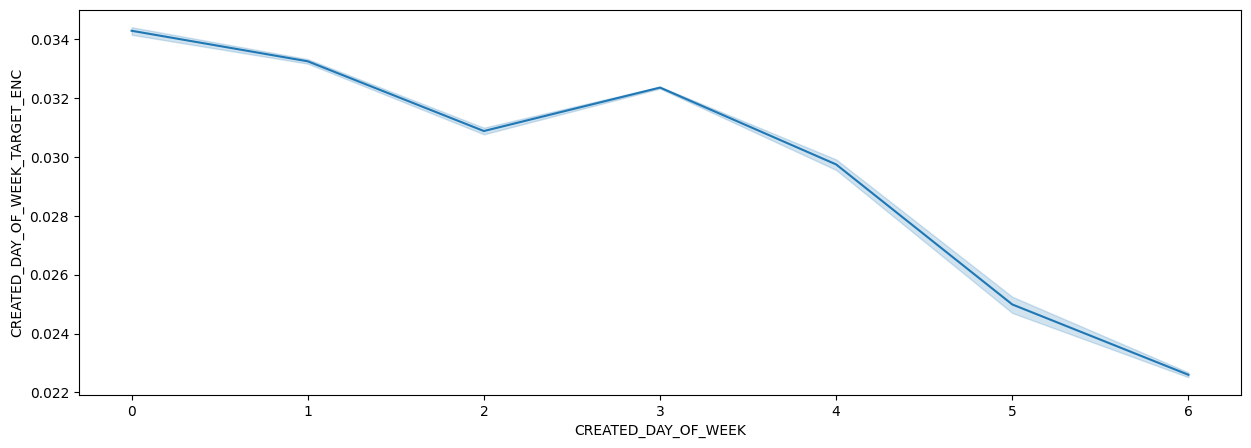

In [49]:
# visualize 'CREATED_YYYY-MM_TARGET_ENC' over time
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_users, x='CREATED_DAY_OF_WEEK', y='CREATED_DAY_OF_WEEK_TARGET_ENC')
plt.show()

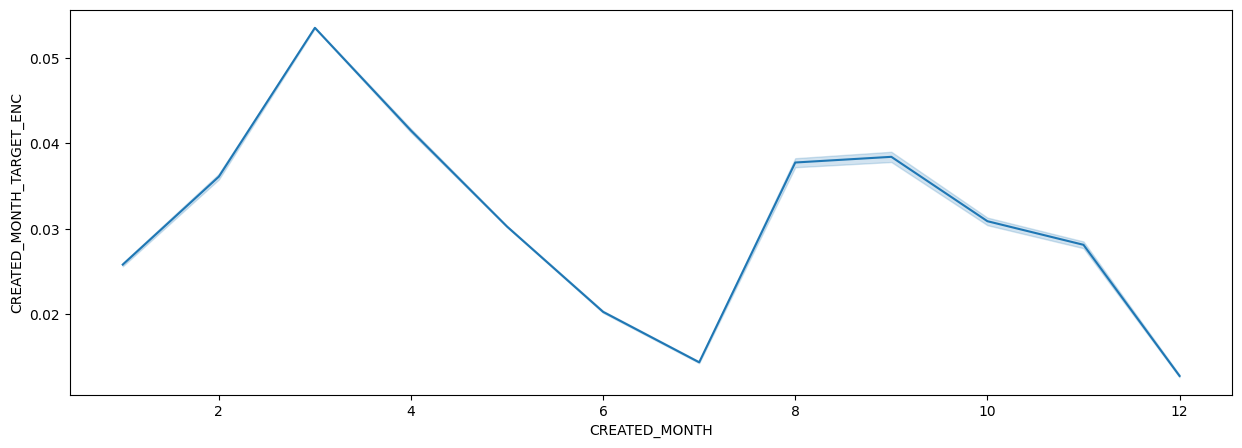

In [50]:
# visualize 'CREATED_YYYY-MM_TARGET_ENC' over time
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_users, x='CREATED_MONTH', y='CREATED_MONTH_TARGET_ENC')
plt.show()

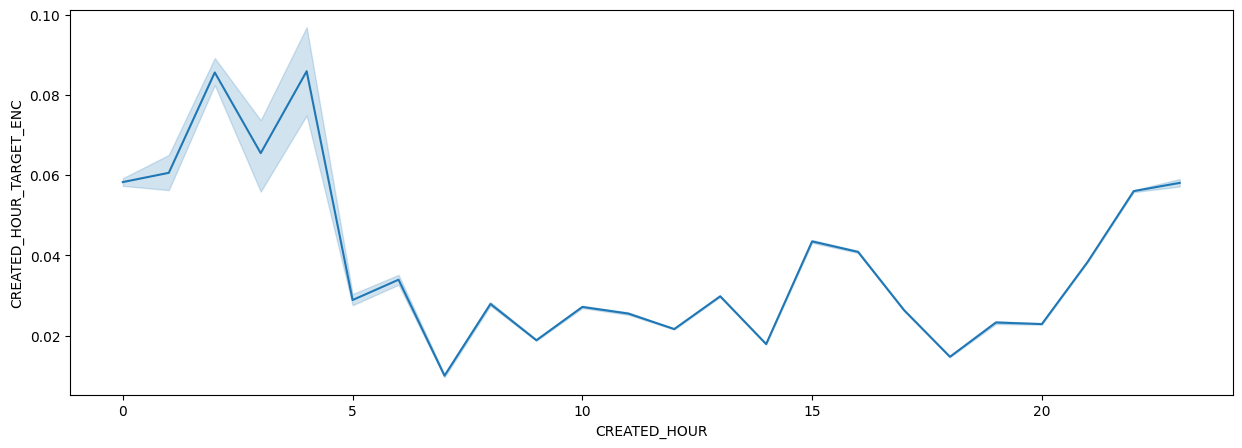

In [51]:
# visualize 'CREATED_YYYY-MM_TARGET_ENC' over time
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_users, x='CREATED_HOUR', y='CREATED_HOUR_TARGET_ENC')
plt.show()

In [118]:
# get YYYY-MM from 'CREATED_DATE' column
pd.to_datetime(df_users['CREATED_DATE']).dt.to_period('M').nunique()

31

In [90]:
df_countries = pd.read_csv('datasets/Revolut/countries.csv')
# drop 'Namibia' because it has 0 users
df_countries.dropna(inplace=True)
df_countries.head()

,CODE,NAME,CODE3,NUMCODE,PHONECODE
0,AF,Afghanistan,AFG,4,93
1,AL,Albania,ALB,8,355
2,DZ,Algeria,DZA,12,213
3,AS,American Samoa,ASM,16,1684
4,AO,Angola,AGO,24,244


In [93]:
df_countries[df_countries['CODE3'] == 'AFN']

,CODE,NAME,CODE3,NUMCODE,PHONECODE


In [23]:
df_currency_details = pd.read_csv('datasets/Revolut/currency_details.csv')
df_currency_details.head(2)

,CCY,EXPONENT,IS_CRYPTO
0,AED,2,False
1,AFN,2,False


In [24]:
# No null values in df_currency_details
df_currency_details.isnull().sum()

CCY          0
EXPONENT     0
IS_CRYPTO    0
dtype: int64